In [1]:
import cv2
import torch
import math
from random import sample
import numpy as np
np.set_printoptions(precision=3, suppress = True)

In [2]:
class EM_expectation:
  def __init__(self, img, k):
      self.img = img #Image
      self.k = k #Number of clusters
      self.alpha = np.zeros(k) #Initial prior probability
      self.mean = np.zeros(k) #Initial mean
      self.sigma = [k] * k #Variance is initialized into k (Obviously, this is up to people coding EM algorithm!)
  def initialization(self): #Find the initial parameters
      height, width = self.img_process()
      x_coords = np.random.randint(0, height, self.k)
      y_coords = np.random.randint(0, width, self.k)
      self.alpha = [1/(height * width) for i in range(len(self.alpha))]
      self.mean =  [self.img[height][width] for height, width in zip(x_coords, y_coords)]
      return
  def gaussian(self, x, mean, sigma):
      coefficient = 1 / math.sqrt(2 * math.pi * sigma**2)
      if x > mean:
        exponent = math.exp(-((x - mean)**2) / (2 * sigma**2))
      else:
        exponent = math.exp(-((mean - x)** 2)/ (2* sigma **2))
      return coefficient * exponent
  def calculate_probabilities(self, pixel_value): #Find the likelihood
      probabilities = []
      for i in range(self.k):
        probabilities.append(self.alpha[i] * self.gaussian(pixel_value, self.mean[i], self.sigma[i]))
      return probabilities #A list containing the probability of each point being located in each clusters.
  def clustering(self, height, width): #parameters : centroid, (list)
      clustering_group = []
      pixel_group = []
      probability_group = []
      for a in range(self.k):
        dist = []
        pixel = []
        probability = []
        for i in range(height):
          for j in range(width):
            d = self.calculate_probabilities(self.img[i][j]) #Copy distances between a point and centroids
            for p in range(len(d)):
              if d[p] == max(d) and p == a: #Find a minimum distance point and if it belongs to kth centroid, append it
                dist.append(self.img[i][j]) #Find the pixel at which d is at minimum within the cluster
                pixel.append((i, j))
                probability.append(max(d))
        clustering_group.append(dist) #Append the list to clustrering_group
        pixel_group.append(pixel)
        probability_group.append(probability)
      return clustering_group, pixel_group, probability_group #Return 2d array
  def assinging_values(self, pixel_group, clustering_group):
      for i in range(len(clustering_group)):
        target_values = self.mean[i]
        for j in range(len(clustering_group[i])):
          height, width = pixel_group[i][j]
          self.img[height][width] = target_values
  def img_process(self):
      height = self.img.shape[0]
      width = self.img.shape[1]
      return height, width
  def E_step(self):
      height, width = self.img_process() #Obtain the height and width of the image
      clustering_group, pixel_group, probability_group = self.clustering(height, width) #Clustering the image with k clusters and obtaiing image valuses of each cluster and their locations
      return clustering_group, pixel_group, probability_group
  def M_step(self, clustering_group, pixel_group, probability_group):
      for i in range(self.k):
        mean, sigma, alpha, probability_sum = 0, 0, 0, 0
        for j in range(len(clustering_group[i])):
          mean += (clustering_group[i][j] * probability_group[i][j])
          if clustering_group[i][j] > self.mean[i]:
            sigma += ((clustering_group[i][j] - self.mean[i]) ** 2 * probability_group[i][j])
          else:
            sigma += ((self.mean[i] - clustering_group[i][j]) ** 2 * probability_group[i][j])
          probability_sum += probability_group[i][j]
        self.mean[i] = mean/probability_sum
        self.sigma[i] = np.sqrt(sigma/probability_sum)
        self.alpha[i] = probability_sum/(len(clustering_group[i]))

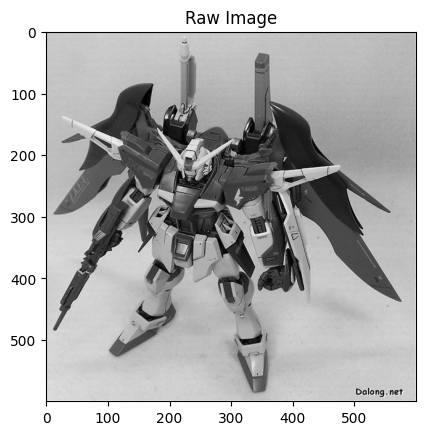

In [3]:
import matplotlib.pyplot as plt
def load_raw_file(file_path, dtype, shape):

    with open(file_path, 'rb') as file:
        data = np.fromfile(file, dtype=dtype)
    return data.reshape(shape)

# Example usage
file_path = '/content/Gundam.raw'
dtype = np.uint8  # or np.float32, np.int16, etc.
shape = (600, 600)
img = load_raw_file(file_path, dtype, shape)
plt.imshow(img, cmap='gray')
plt.title('Raw Image')
plt.show()

In [4]:
img = load_raw_file(file_path, dtype, shape)
k = 2 #Number of clusters
n_step = 10
EM = EM_expectation(img, k)
EM.initialization()
for i in range(n_step):
  clustering_group, pixel_group, probability_group = EM.E_step() #return the locations and values of each cluster.
  EM.M_step(clustering_group, pixel_group, probability_group) #Updating : find new centroids of each cluster and return the location of them
  print("Mean : ", np.array(EM.mean), "Sigma : ", np.array(EM.sigma), "Mixing_probability : ", EM.alpha)
EM.assinging_values(pixel_group, clustering_group) #Assigning the image with the centroid of each cluster

Mean :  [252.35  107.885] Sigma :  [1.834 2.014] Mixing_probability :  [5.123872051388798e-10, 7.01007539616881e-09]
Mean :  [251.934 107.767] Sigma :  [1.686 2.027] Mixing_probability :  [1.1163216613691117e-13, 1.647192451352298e-11]
Mean :  [251.648 107.647] Sigma :  [1.548 2.039] Mixing_probability :  [2.6601902523904497e-17, 3.317879941576611e-14]
Mean :  [251.451 107.524] Sigma :  [1.413 2.051] Mixing_probability :  [6.598286069468973e-21, 5.721548633072736e-17]
Mean :  [251.322 107.399] Sigma :  [1.282 2.061] Mixing_probability :  [1.6870105931902314e-24, 8.707235126323282e-20]
Mean :  [251.247 107.273] Sigma :  [1.158 2.07 ] Mixing_probability :  [4.422103060731087e-28, 1.1681045589897354e-22]
Mean :  [251.215 107.145] Sigma :  [1.046 2.079] Mixing_probability :  [1.1842876993353866e-31, 1.4570355263476762e-25]
Mean :  [251.213 107.015] Sigma :  [0.949 2.085] Mixing_probability :  [3.2319577937382607e-35, 1.7466026437190925e-28]
Mean :  [251.231 106.885] Sigma :  [0.867 2.091] 

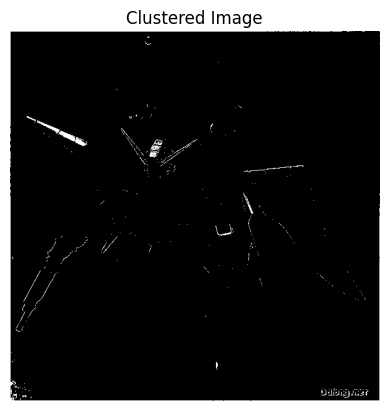

In [5]:
import matplotlib.pyplot as plt
plt.imshow(EM.img, cmap='gray')
plt.title('Clustered Image')
plt.axis('off')  # Hide axes for better visualization
plt.show()

In [6]:
img = load_raw_file(file_path, dtype, shape) #Mixing probabilities are truncated since they are extremely small due to a great number of pixels
k = 4 #Number of clusters
n_step = 10
EM = EM_expectation(img, k)
EM.initialization()
for i in range(n_step):
  clustering_group, pixel_group, probability_group = EM.E_step() #return the locations and values of each cluster.
  EM.M_step(clustering_group, pixel_group, probability_group) #Updating : find new centroids of each cluster and return the location of them
  print("Mean : ", np.array(EM.mean), "Sigma : ", np.array(EM.sigma), "Mixing_probability : ", EM.alpha)
EM.assinging_values(pixel_group, clustering_group) #Assigning the image with the centroid of each cluster

Mean :  [154.737 178.934 193.292 167.165] Sigma :  [3.231 3.298 3.777 2.945] Mixing_probability :  [2.4982795361195082e-08, 1.7755069239750634e-07, 1.0357091805847296e-07, 1.9575195250288645e-07]
Mean :  [154.998 179.548 193.591 167.286] Sigma :  [2.522 3.082 3.568 2.632] Mixing_probability :  [2.4133554667880764e-10, 8.891214997457171e-09, 3.6423801753705856e-09, 8.94358597688081e-09]
Mean :  [155.243 180.087 193.789 167.535] Sigma :  [2.143 2.869 3.452 2.536] Mixing_probability :  [2.6958530923933576e-12, 3.561756317564155e-10, 1.1209822793642926e-10, 2.615169879287146e-10]
Mean :  [155.261 180.583 194.055 167.757] Sigma :  [1.755 2.814 3.3   2.451] Mixing_probability :  [4.083138297560821e-14, 1.3208085282614906e-11, 3.044697618050549e-12, 6.960222390819925e-12]
Mean :  [155.347 181.031 194.249 167.962] Sigma :  [1.543 2.759 3.217 2.365] Mixing_probability :  [7.021872400516964e-16, 4.666982462340763e-13, 8.366039673786844e-14, 1.4275873372776612e-13]
Mean :  [155.437 181.507 194.54

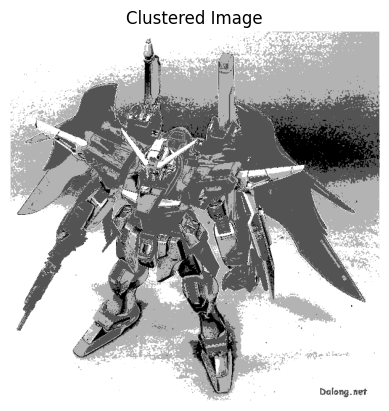

In [7]:
import matplotlib.pyplot as plt
plt.imshow(EM.img, cmap='gray')
plt.title('Clustered Image')
plt.axis('off')  # Hide axes for better visualization
plt.show()

In [8]:
img = load_raw_file(file_path, dtype, shape) #Mixing probabilities are truncated since they are extremely small due to a great number of pixels
k = 8 #Number of clusters
n_step = 10
EM = EM_expectation(img, k)
EM.initialization()
for i in range(n_step):
  clustering_group, pixel_group, probability_group = EM.E_step() #E-step
  EM.M_step(clustering_group, pixel_group, probability_group) #M-step
  print("Mean : ", np.array(EM.mean), "Sigma : ", np.array(EM.sigma), "Mixing_probability : ", np.array(EM.alpha))
EM.assinging_values(pixel_group, clustering_group) #Assigning the image with average gray level of each cluster

Mean :  [184.974 209.512  20.138 131.276 105.915 196.169  58.323 203.239] Sigma :  [5.313 3.879 8.251 7.262 7.707 2.583 7.829 2.427] Mixing_probability :  [0. 0. 0. 0. 0. 0. 0. 0.]
Mean :  [185.081 209.839  23.051 132.701 103.582 195.981  59.583 202.813] Sigma :  [4.088 2.22  7.982 6.765 7.559 1.977 7.579 1.762] Mixing_probability :  [0. 0. 0. 0. 0. 0. 0. 0.]
Mean :  [185.461 209.687  25.388 133.717 101.618 195.963  60.718 202.616] Sigma :  [3.455 1.74  7.304 6.416 7.534 1.76  7.301 1.508] Mixing_probability :  [0. 0. 0. 0. 0. 0. 0. 0.]
Mean :  [185.612 209.54   27.126 134.425  99.816 195.956  61.748 202.473] Sigma :  [2.868 1.5   6.524 6.229 7.434 1.674 7.011 1.36 ] Mixing_probability :  [0. 0. 0. 0. 0. 0. 0. 0.]
Mean :  [185.849 209.417  28.33  135.058  98.165 195.966  62.636 202.355] Sigma :  [2.514 1.346 5.773 6.099 7.285 1.61  6.729 1.255] Mixing_probability :  [0. 0. 0. 0. 0. 0. 0. 0.]
Mean :  [186.083 209.313  29.128 135.599  96.715 195.987  63.399 202.255] Sigma :  [2.262 1.237

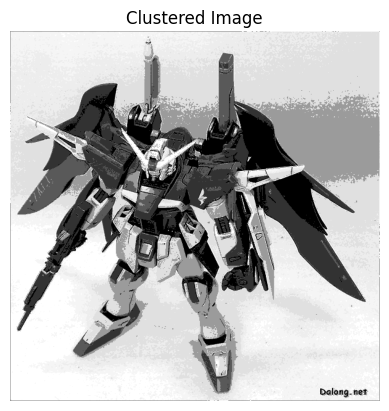

In [9]:
import matplotlib.pyplot as plt
plt.imshow(EM.img, cmap='gray')
plt.title('Clustered Image')
plt.axis('off')  # Hide axes for better visualization
plt.show()

Note that since it takes too long time for all parameters in EM to reach convergence, I rather iterate for exactly ten times. All parameters are almost converged as shown by values of each parameters. Therefore, the resultant images are likely to be almost identical to the actual converged resultant images.